Questions trying to answer:

1. CA state prevalence rate 
2. CA state new diagnosis rate 
3. County prevalence rate
4. County diagnoses over time
5. State prevalence over time by race
6. State new diagnosis over time by race
7. County prevalence over time by race
8. County diagnoses over time by race


Resources:
Atlas - where all the data are coming from: https://www.cdc.gov/nchhstp/atlas/index.htm
Atlas Glossary - https://gis.cdc.gov/grasp/nchhstpatlas/Content/docs/AtlasPlusGlossary.pdf

In [1]:
#Ignores all warnings
import warnings
warnings.filterwarnings('ignore') 

In [2]:
import numpy as np #Fundamental package for scientific computing
import pandas as pd #For data manipulation and analysis
import matplotlib.pyplot as plt #2D plotting library
import seaborn as sns #Python data visualization library based on matplotlib

In [3]:
def make_numeric(df, col):
    
    """ Convert a column to numeric, stripping commas first """
    
    data = df.copy()
    
    data[col] = data[col].apply(lambda x: str(x).replace(",",""))
    data[col] = pd.to_numeric(data[col], errors='coerce')
    
    return data

In [4]:
def get_data(fname, numeric_columns=["Cases", "Rate per 100000", "Population"],
                   filter_by=lambda x: 1==1):
    
    """ get a dataframe from a CSV generated by atlas """
    
    data = pd.read_csv(fname,skiprows=7)
    
    for c in numeric_columns:
        if c not in data.columns.tolist(): continue
        data = make_numeric(data, c)
    
    data = data[data.apply(filter_by, axis=1)]

    return data
    
get_data("state-prev-race.csv").head()

,Indicator,Year,Geography,FIPS,Age Group,Race/Ethnicity,Sex,Transmission Category,Cases,Rate per 100000,Population
0,HIV prevalence,2022,Alabama^,1,Ages 13 years and older,Multiracial,Both sexes,All transmission categories,973,1682.6,57827
1,HIV prevalence,2022,Alabama^,1,Ages 13 years and older,White,Both sexes,All transmission categories,3921,137.8,2845870
2,HIV prevalence,2022,Alabama^,1,Ages 13 years and older,Native Hawaiian/Other Pacific Islander,Both sexes,All transmission categories,3,135.6,2212
3,HIV prevalence,2022,Alabama^,1,Ages 13 years and older,Hispanic/Latino,Both sexes,All transmission categories,598,331.8,180224
4,HIV prevalence,2022,Alabama^,1,Ages 13 years and older,Black/African American,Both sexes,All transmission categories,9173,823.1,1114447


In [5]:
get_data("us-newdiagnosis-overall.csv").head()

,Indicator,Year,Geography,FIPS,Age Group,Race/Ethnicity,Sex,Transmission Category,Cases,Rate per 100000,Population
0,HIV diagnoses,2022,United States,NaN,Ages 13 years and older,All races/ethnicities,Both sexes,All transmission categories,37601,13.3,282494087
1,HIV diagnoses,2021,United States,NaN,Ages 13 years and older,All races/ethnicities,Both sexes,All transmission categories,35671,12.7,280875761
2,HIV diagnoses,2020 (COVID-19 Pandemic),United States,NaN,Ages 13 years and older,All races/ethnicities,Both sexes,All transmission categories,30317,10.8,279604644
3,HIV diagnoses,2019,United States,NaN,Ages 13 years and older,All races/ethnicities,Both sexes,All transmission categories,36350,13.2,276063213
4,HIV diagnoses,2018,United States,NaN,Ages 13 years and older,All races/ethnicities,Both sexes,All transmission categories,37132,13.5,274284600


In [6]:
def time_series(df, cols="Year", vals="Rate per 100000", index = "Geography"):
    
    """ Convert a dataframe to a timeseries with one column per year """
    
    return pd.pivot_table(df, columns=cols, 
                         values=vals,
                         index = index)




print ("Overall U.S. HIV prevalence rates per 100,000")
time_series(get_data("us-prev-overall.csv")).head()

Overall U.S. HIV prevalence rates per 100,000


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,369.9,375.6,375.4,380.3,386.6


In [7]:
def sub_timeseries(df, sub_col="Race/Ethnicity", cols="Year", vals="Rate per 100000", index="Geography"):
    
    """ Generate a dictionary of time series dataframes for a each unique value of a given sub_col """
        
    data = {}
    
    for subg in df[sub_col].unique():
        data[subg] = time_series(df[df[sub_col] == subg],
                               cols=cols,
                               vals=vals,
                               index=index)
        
    return data
        
print("""We have generated a separate time series dataframe for 
      state-level prevalence rates for each of the following race groups:""") 

sub_timeseries(get_data("state-prev-race.csv")).keys()

We have generated a separate time series dataframe for 
      state-level prevalence rates for each of the following race groups:


dict_keys(['Multiracial', 'White', 'Native Hawaiian/Other Pacific Islander', 'Hispanic/Latino', 'Black/African American', 'Asian', 'American Indian/Alaska Native'])

In [8]:
def disparity_ratio(series_a, series_b):
    
    """ Generate a disparity ratio series from two series. Assumes a common key like geography or FIPS """
    
    return (series_a / series_b)#.sort_values(ascending=False)
    
    
print ("Nationwide, 2019 black-white prevalence ratio")
disparity_ratio(sub_timeseries(get_data("us-prev-race.csv"))["Black/African American"]["2019"],
                sub_timeseries(get_data("us-prev-race.csv"))["White"]["2019"])


Nationwide, 2019 black-white prevalence ratio


Geography
United States    7.049482
Name: 2019, dtype: float64

In [9]:
n = sub_timeseries(get_data("state-prev-race.csv"))["Black/African American"].loc["California"]["2019"]
d = sub_timeseries(get_data("state-prev-race.csv"))["White"].loc["California"]["2019"]

print ("California, 2019 black-white prevalence disparity ratio")
print (n, d, n / d)

California, 2019 black-white prevalence disparity ratio
1104.5 365.0 3.026027397260274


In [10]:
def disparity_ratio_timeseries(dfa, dfb):
    
    """ Create a table of disparity ratios from two tables """
    
    data = None
    for c in filter(lambda x: x in dfb.columns.tolist(), dfa.columns.tolist()):
        
        if data is None:
            data = disparity_ratio(dfa[c], dfb[c]).to_frame()
        else:
            data[c] = disparity_ratio(dfa[c], dfb[c]).to_frame()
            
    return data

print ("State-level black-white prevalence disparity")
        
disparity_ratio_timeseries(
    sub_timeseries(get_data("state-prev-race.csv"))["Black/African American"],
    sub_timeseries(get_data("state-prev-race.csv"))["White"]
).sort_values(by="2019", ascending=False).dropna(how="all")

State-level black-white prevalence disparity


,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
North Dakota,24.655440,26.165432,26.326829,27.549878,26.815534
South Dakota,18.862745,20.177165,19.648855,18.344322,17.416520
Maine,15.796226,16.010290,15.565176,14.854323,15.197053
Idaho,14.925758,15.017544,15.124251,14.906344,14.348802
Wisconsin,12.284247,12.588832,12.686242,12.766831,12.697712
Pennsylvania,12.168908,12.040496,11.960866,11.786066,11.540800
New Hampshire,11.917722,11.351418,11.245074,11.179641,11.287070
Minnesota,11.171717,11.023976,10.842473,10.800198,10.615310
Utah,11.055866,10.965746,10.925439,11.020585,10.783080


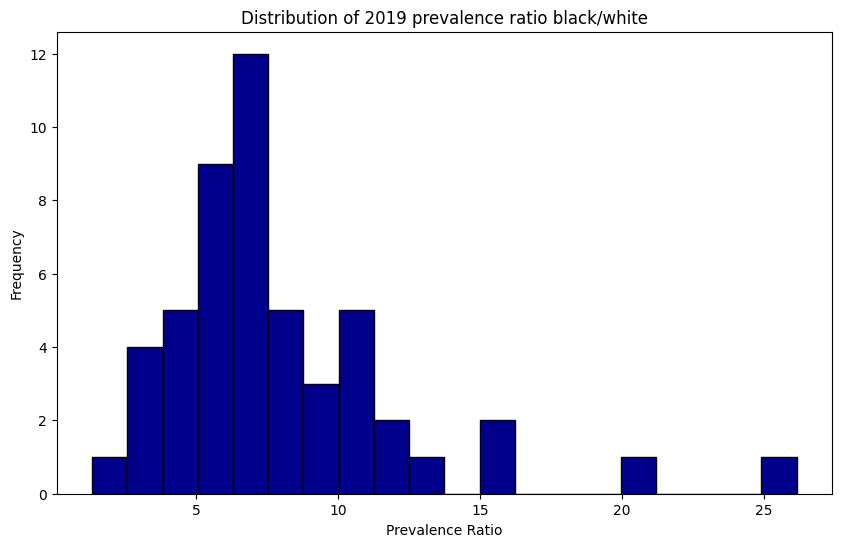

In [11]:
import matplotlib.pyplot as plt

# Generate the data
data = disparity_ratio_timeseries(
    sub_timeseries(get_data("state-prev-race.csv"))["Black/African American"],
    sub_timeseries(get_data("state-prev-race.csv"))["White"]
)["2019"]

# Set the figure size and plot
plt.figure(figsize=(10, 6))  # Width = 10, Height = 6
data.plot.hist(
    title="Distribution of 2019 prevalence ratio black/white",
    color='darkblue',# Choose your desired color
    edgecolor='black',
    bins=20  # Adjust the number of bins if needed
)

# Add labels and show the plot
plt.xlabel("Prevalence Ratio")
plt.ylabel("Frequency")
plt.show()

In [12]:
print ("Distribution of 2019 prevalence ratio black/white")

disparity_ratio_timeseries(
    sub_timeseries(get_data("state-prev-race.csv"))["Black/African American"],
    sub_timeseries(get_data("state-prev-race.csv"))["White"]
)["2019"].describe()

Distribution of 2019 prevalence ratio black/white


count    51.000000
mean      7.962621
std       4.314181
min       1.335819
25%       5.660331
50%       6.833696
75%       9.624191
max      26.165432
Name: 2019, dtype: float64

### Autoloading tables with multiple columns

In [13]:
import itertools
import collections
from functools import reduce

# Solution here: https://gist.github.com/angstwad/bf22d1822c38a92ec0a9
def dict_merge(dct, merge_dct):
    """ Recursive dict merge. Inspired by :meth:``dict.update()``, instead of
    updating only top-level keys, dict_merge recurses down into dicts nested
    to an arbitrary depth, updating keys. The ``merge_dct`` is merged into
    ``dct``.
    :param dct: dict onto which the merge is executed
    :param merge_dct: dct merged into dct
    :return: None
    """
    for k, v in merge_dct.items():
        if (k in dct and isinstance(dct[k], dict)
                and isinstance(merge_dct[k], collections.abc.Mapping)):
            dict_merge(dct[k], merge_dct[k])
        else:
            dct[k] = merge_dct[k]
            
def multi_sub_timeseries(df, sub_cols=["Race/Ethnicity", "Sex"], 
                   cols="Year", 
                   vals="Rate per 100000", 
                   index="Geography"):
    
    """ Generate a dict of time series with multiple variable columns, such as by race and gender """

    group_arrs = list(map(lambda x: df[x].unique(), sub_cols))

    def reduce_perm(perm):
        return reduce((lambda x, y: {y:x}), reversed(perm + [None]))
    
    permutations = [list(x) for x in list(itertools.product(*group_arrs))]
    
    for p in permutations:
        pass
    #print reduce_perm(p)
        
    data = {}
    
    for perm_dict in permutations:
        dict_merge(data, reduce_perm(perm_dict))
                
            
    def walk(frame, node, level):
        nodeframe = frame.copy()
        
        if node is None:
            leafdf = time_series(nodeframe,
                               vals=vals, 
                               index=index)
            return leafdf
    
        for k in node.keys():
            nf = nodeframe.copy()
            nf = nf[nf[sub_cols[level]] == k]
            node[k] = walk(nf, node[k], level+1)
        
        return node
    walk(df, data, 0)
    
    return data



print (multi_sub_timeseries(get_data("us-prev-race-gender.csv"))["White"]["Male"])
print (multi_sub_timeseries(get_data("us-prev-race-gender.csv"))["Black/African American"]["Male"])


print ("Black-white prevalence disparity ratio")
disparity_ratio_timeseries(
    multi_sub_timeseries(get_data("us-prev-race-gender.csv"))["Black/African American"]["Male"],
    multi_sub_timeseries(get_data("us-prev-race-gender.csv"))["White"]["Male"],
)

Year            2018   2019  2020 (COVID-19 Pandemic)   2021   2022
Geography                                                          
United States  304.7  308.3                     305.9  309.4  313.1
Year             2018    2019  2020 (COVID-19 Pandemic)    2021    2022
Geography                                                              
United States  1699.6  1727.0                    1711.0  1734.6  1759.7
Black-white prevalence disparity ratio


,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,5.577946,5.601687,5.593331,5.606335,5.620249


In [14]:
import us

def state_name(geography):
    """
    Converts a geography input (state abbreviation, FIPS code, or name) 
    into the full state name using the `us` library.
    """
    # Handle geography in the form of "County, State Abbreviation"
    if ", " in str(geography):
        state_abbr = geography.split(", ")[-1]
        state = us.states.lookup(state_abbr)
        if state:
            return state.name
    
    # Handle numeric inputs (FIPS codes)
    try:
        fips_code = str(geography).zfill(2)  # Zero-pad for FIPS codes
        state = us.states.lookup(fips_code)
        if state:
            return state.name
    except Exception as e:
        print(f"Error processing FIPS code: {e}")
    
    # Handle direct state names or abbreviations
    state = us.states.lookup(geography)
    if state:
        return state.name
    
    # Fallback for unrecognized inputs
    return f"Unrecognized geography: {geography}"

# Test cases
print(state_name("Abbeville County, CA"))  # Should return "California"
print(state_name(6))                       # Should return "California" (FIPS code)
print(state_name("CA"))                    # Should return "California"
print(state_name("Placer County, CA"))  # Should return "California"
print(state_name("Unknown"))

California
California
California
California
Unrecognized geography: Unknown


In [67]:
def is_California(st, allow_us=True, CA_only=False):
    # List of valid identifiers for California
    California = ["California", "CA"]
    
    # Determine the allowed identifiers based on function arguments
    if allow_us:
        state = California + ["United States"]
    elif CA_only:
        state = ["California"]
    else:
        state = California

    # Split the input into words and match against valid identifiers
    st_words = st.upper().strip().split(",")  # Split by comma, strip whitespace
    st_clean = [word.strip() for word in st_words]  # Normalize and clean each word

    # Strict equality check to avoid substring issues
    return any(identifier.upper() in st_clean for identifier in state)

def just_California(df, allow_us=True, CA_only=False):
    return df[df.index.map(lambda x: is_California(x, allow_us=allow_us, CA_only=CA_only))]

just_California(
    time_series(
        pd.concat([
            get_data("state-newdiagnosis-overall.csv"),
            get_data("us-newdiagnosis-overall.csv")
        ])
    )
)

Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
California,14.6,13.8,12.3,13.7,14.7
United States,13.5,13.2,10.8,12.7,13.3


In [16]:
import matplotlib.pyplot as plt

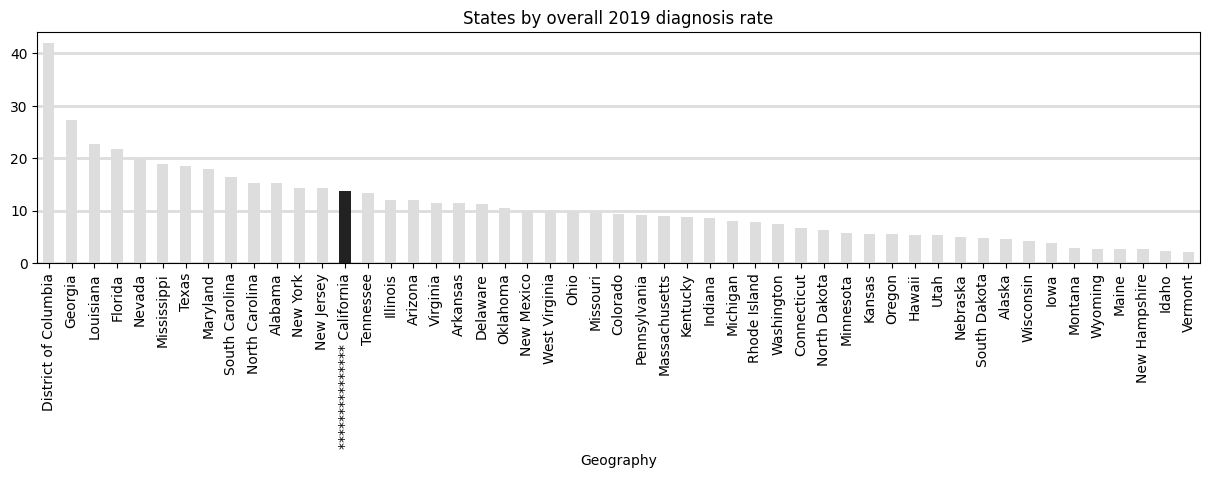

In [64]:
def state_bars(ser, title=None):
    
    def pick_color(l):
        if is_California(l):
            return "#222222"  # Highlight California
        return "#dddddd"  # Default color
    
    # Generate colors based on the labels
    colors = ser.sort_values(ascending=False).index.map(pick_color).tolist()
    
    # Create the bar plot
    ax = ser.plot.bar(figsize=(15, 3), color=colors, title=title)
    

    def format_func(value, tick_number):
        lbl = ser.index[tick_number]
        if is_California(lbl):
            lbl = ("*" * (25 - len(lbl))) + " " + lbl
        return lbl
    
    
    
    ax.grid(color="#dddddd", linestyle='-', linewidth=2, axis='y')
    
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_axisbelow(True)

state_bars(time_series(get_data("state-newdiagnosis-overall.csv"))["2019"].sort_values(ascending=False),
          title="States by overall 2019 diagnosis rate")

In [65]:
just_California(
    time_series(
        pd.concat([
            get_data("us-prev-overall.csv"),
            get_data("state-prev-overall.csv")
        ]
    ),
         vals="Cases")
)

Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
California,130259.0,132793.0,134208.0,136160.0,138531.0
United States,1014481.0,1036801.0,1049709.0,1068119.0,1092023.0


In [19]:
print ("Total New England HIV cases (prevalence)")

just_California(
    time_series(
            get_data("state-prev-overall.csv"),
            vals="Cases"
    ),
).sum().to_frame().transpose()

Total New England HIV cases (prevalence)


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
0,130259.0,132793.0,134208.0,136160.0,138531.0


### How many people were diagnosed with HIV each year?

In [20]:
print ("U.S. and California HIV diagnoses per year")

just_California(
    time_series(
        pd.concat([
            get_data("us-newdiagnosis-overall.csv"),
            get_data("state-newdiagnosis-overall.csv")
        ]
    ),
         vals="Cases")
)

U.S. and California HIV diagnoses per year


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
California,4808.0,4571.0,4097.0,4539.0,4856.0
United States,37132.0,36350.0,30317.0,35671.0,37601.0


In [21]:
print ("Total California HIV diagnoses per year")

just_California(
    time_series(
        get_data("state-newdiagnosis-overall.csv"),
        vals="Cases"
    )
).sum().to_frame().transpose()

Total California HIV diagnoses per year


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
0,4808.0,4571.0,4097.0,4539.0,4856.0


In [22]:
print ("Number of black diagnoses")
just_California(
    multi_sub_timeseries(get_data("state-newdiagnosis-race.csv"),
                         sub_cols=["Race/Ethnicity"],
                         vals="Cases")["Black/African American"]
)

Number of black diagnoses


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
California,786.0,729.0,671.0,758.0,709.0


##### 

In [23]:
print ("Number of hispanic diagnoses")
just_California(
    multi_sub_timeseries(get_data("state-newdiagnosis-race.csv"),
                         sub_cols=["Race/Ethnicity"],
                         vals="Cases")["Hispanic/Latino"]
)

Number of hispanic diagnoses


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
California,2379.0,2343.0,2119.0,2384.0,2768.0


In [24]:
print ("Number of white diagnoses")
just_California(
    multi_sub_timeseries(get_data("state-newdiagnosis-race.csv"),
                         sub_cols=["Race/Ethnicity"],
                         vals="Cases")["White"]
)

Number of white diagnoses


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
California,1143.0,1070.0,949.0,1007.0,999.0


In [25]:
just_California(
    time_series(
            get_data("state-newdiagnosis-overall.csv"),
            vals="Cases"
    ),
).sum().to_frame().transpose()


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
0,4808.0,4571.0,4097.0,4539.0,4856.0


### Question: How does California compare to states nationwide for overall HIV diagnoses and prevalence?

In [26]:
print ("U.S. and California new diagnoses for all groups")
pd.concat([
    just_California(time_series(get_data("state-newdiagnosis-overall.csv"))),
    time_series(get_data("us-newdiagnosis-overall.csv"))]
).sort_values(by="2019",ascending=False)

U.S. and California new diagnoses for all groups


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
California,14.6,13.8,12.3,13.7,14.7
United States,13.5,13.2,10.8,12.7,13.3


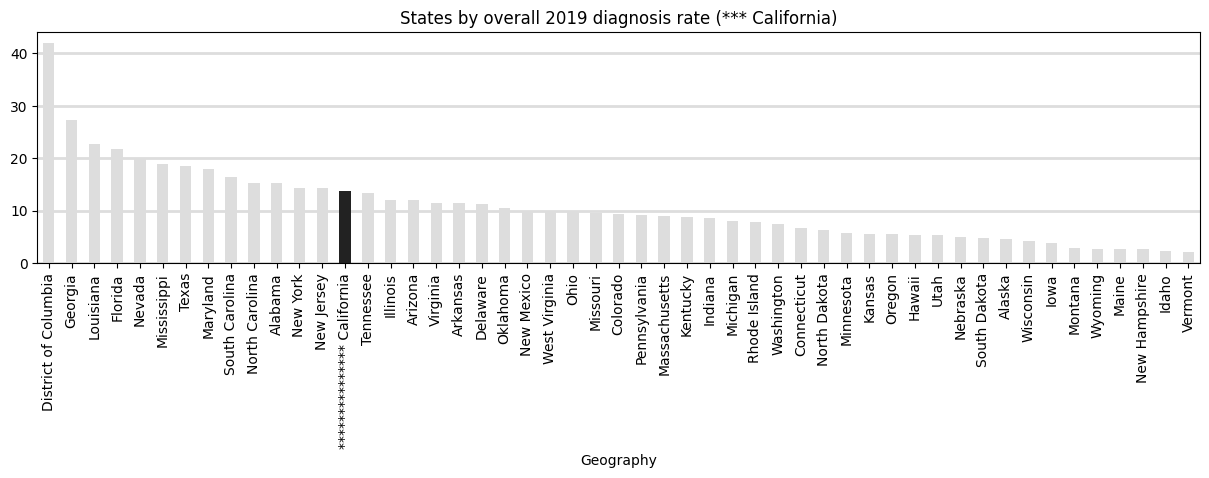

In [27]:
state_bars(time_series(get_data("state-newdiagnosis-overall.csv"))["2019"].sort_values(ascending=False),
          title="States by overall 2019 diagnosis rate (*** California)")

In [28]:
print ("U.S. and California state Prevalence for all groups")

pd.concat([
    time_series(get_data("us-prev-overall.csv")),
    just_California(time_series(get_data("state-prev-overall.csv")))
]).sort_values(by="2018",ascending=False)

U.S. and California state Prevalence for all groups


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
California,394.9,401.5,403.5,411.7,418.7
United States,369.9,375.6,375.4,380.3,386.6


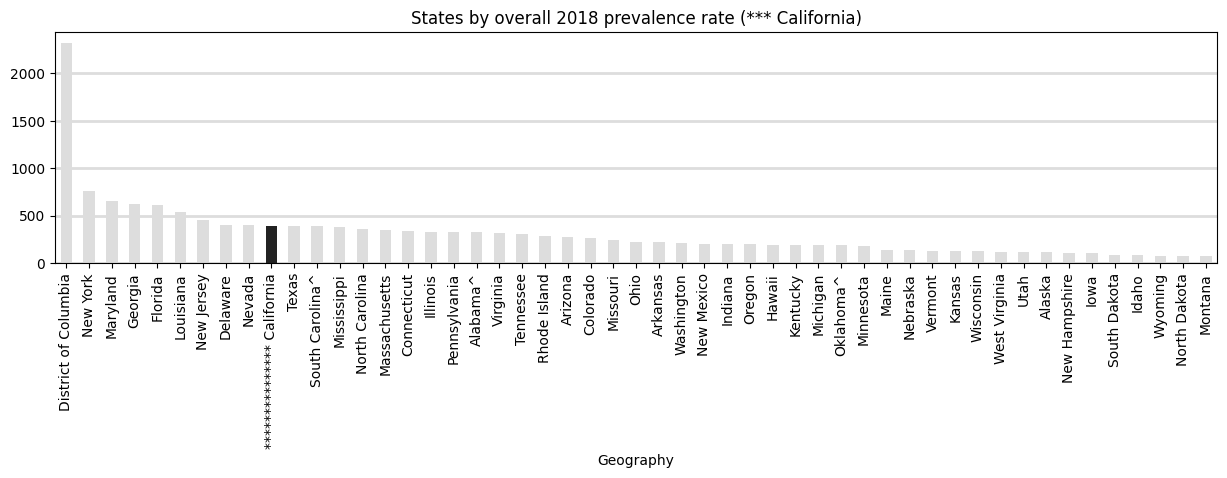

In [29]:
state_bars(time_series(get_data("state-prev-overall.csv"))["2018"].sort_values(ascending=False),
          title="States by overall 2018 prevalence rate (*** California)")

### Question: Is that because New England is more white than the nation as a whole?
Let's look at the population breakdown by race for states and the US

White percent of total population, U.S. and California
only for rough approximating purposes, based on adding subgroups


<Axes: title={'center': 'White percent of total population, U.S. and California'}, xlabel='Geography'>

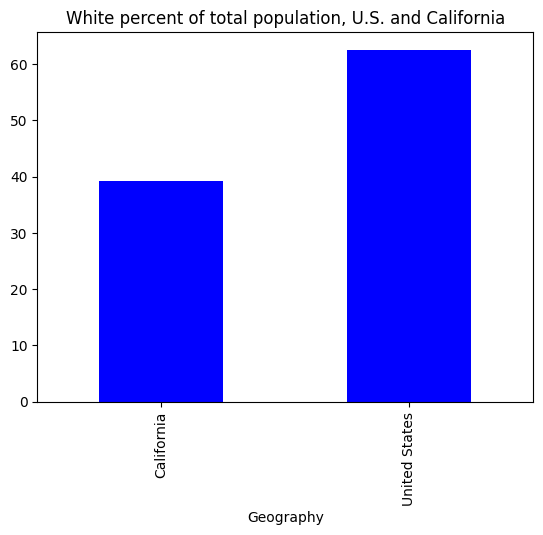

In [30]:
def population_composition(df, year="2018"):
    
    data = df.copy()
    
    data = data[data["Year"] == year]
    
    races = data["Race/Ethnicity"].unique()
    
    data = pd.pivot_table(data,
                        columns="Race/Ethnicity",
                        values="Population",
                        index="Geography")
    
    data["sum"] = data.sum(axis=1)
    
    for r in races:
        data[r] = data[r] * 100 / data["sum"]
        
    return data[data.columns[:-1]]
    


print ("White percent of total population, U.S. and California")
print ("only for rough approximating purposes, based on adding subgroups")
    
just_California(
    population_composition(   
        pd.concat([
            get_data("us-prev-race.csv"),
            get_data("state-prev-race.csv")
        ])
    )
)["White"]\
.sort_values()\
.plot.bar(
    xlim=100,
    legend=None,
    title="White percent of total population, U.S. and California",
    color="blue",
    grid=False
)

In [31]:
print ("White percent of total population, U.S. and California")
print ("only for rough approximating purposes, based on adding subgroups")
    
just_California(
    population_composition(   
        pd.concat([
            get_data("us-prev-race.csv"),
            get_data("state-prev-race.csv")
        ])
    )
)["White"]

White percent of total population, U.S. and California
only for rough approximating purposes, based on adding subgroups


Geography
California       39.213838
United States    62.542313
Name: White, dtype: float64

### State-level diagnosis among racial/ethnic subgroups

In [32]:
def us_state_timeseries(topic, race):
    return pd.concat([
        multi_sub_timeseries(get_data("us-newdiagnosis-race.csv"), sub_cols=["Race/Ethnicity"])[race],
            multi_sub_timeseries(
                get_data("state-newdiagnosis-race.csv"),
                sub_cols=["Race/Ethnicity"])[race]
    ])\
    
def us_CA_timeseries(topic, race):
    return just_California(us_state_timeseries(topic, race))

print
print ("U.S. and California new diagnosis rates for black/african american")

us_CA_timeseries("newdiagnosis","Black/African American").sort_values(by="2019", ascending=False)

U.S. and California new diagnosis rates for black/african american


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,45.7,44.5,36.3,41.2,41.6
California,41.4,38.4,35.1,40.1,37.7


<Axes: xlabel='Geography'>

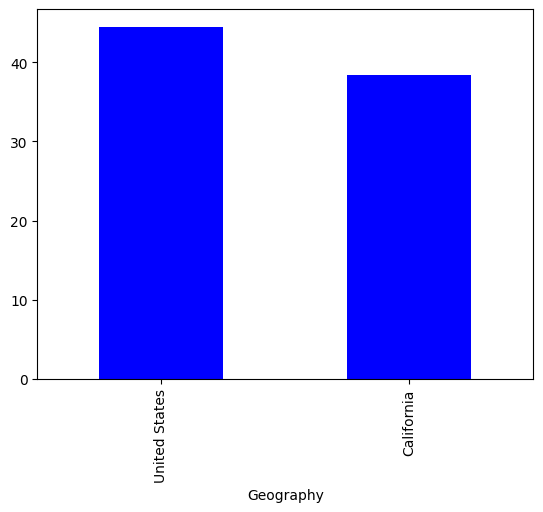

In [33]:
# same as above, as a bar chart
us_CA_timeseries("newdiagnosis","Black/African American").sort_values(by="2019", ascending=False)\
.sort_values(by="2019", ascending=False)["2019"].plot.bar(color="blue")

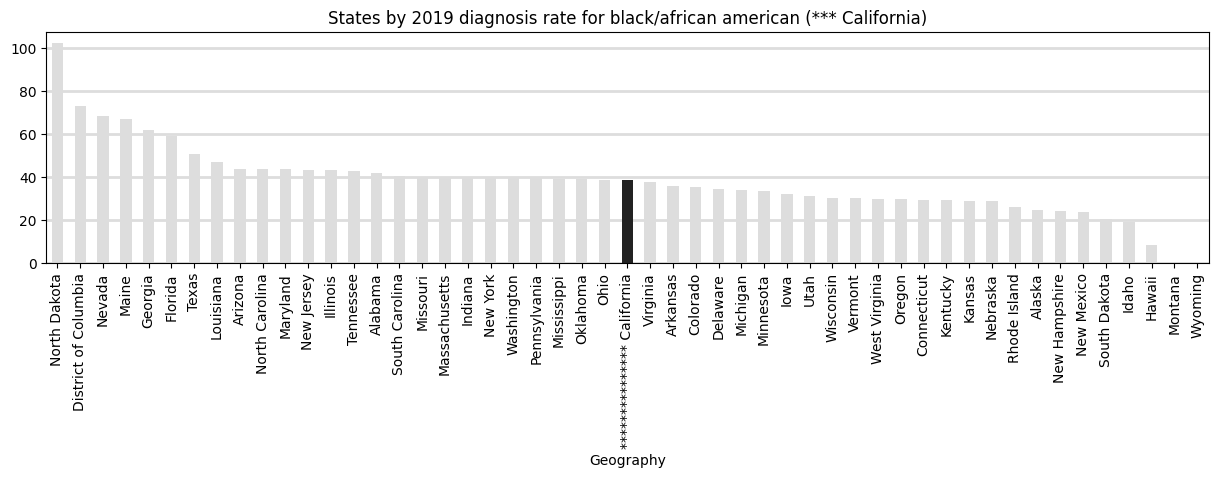

In [34]:
state_bars(
    sub_timeseries(get_data("state-newdiagnosis-race.csv"))["Black/African American"]["2019"].sort_values(ascending=False),
    title="States by 2019 diagnosis rate for black/african american (*** California)"
)

In [35]:
print ("U.S. and California new diagnosis rates for hispanic/latino")

us_CA_timeseries("newdiagnosis","Hispanic/Latino")

U.S. and California new diagnosis rates for hispanic/latino


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,21.6,21.1,16.8,20.5,23.4
California,19.7,19.2,17.0,19.0,21.8


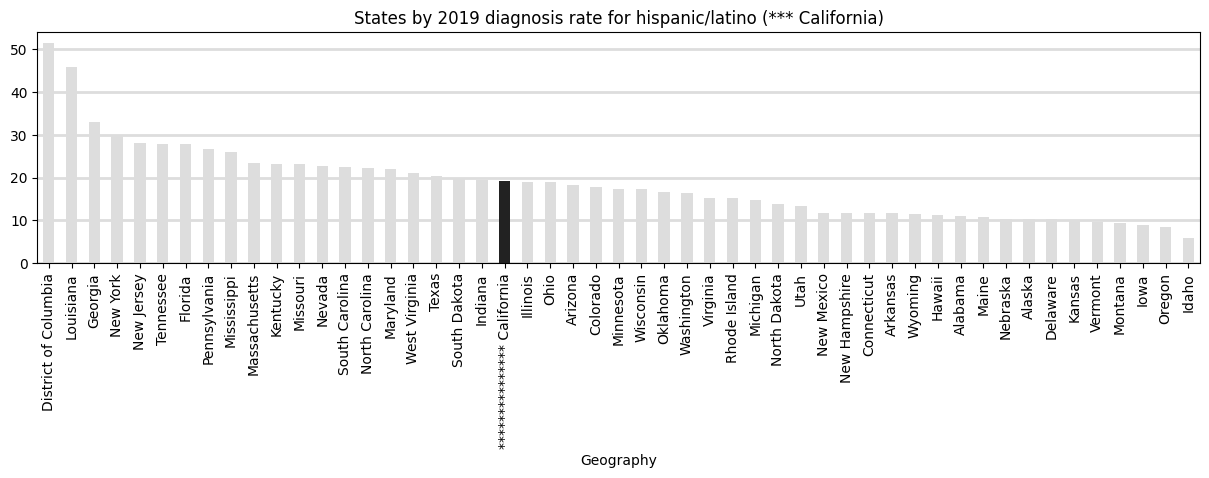

In [36]:
state_bars(
    sub_timeseries(get_data("state-newdiagnosis-race.csv"))["Hispanic/Latino"]["2019"].sort_values(ascending=False),
    title="States by 2019 diagnosis rate for hispanic/latino (*** California)"
)

In [37]:
print ("U.S. and New England states new diagnosis rates for white")

us_CA_timeseries("newdiagnosis","White")

U.S. and New England states new diagnosis rates for white


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,5.4,5.2,4.4,5.2,5.3
California,8.8,8.4,7.5,8.2,8.2


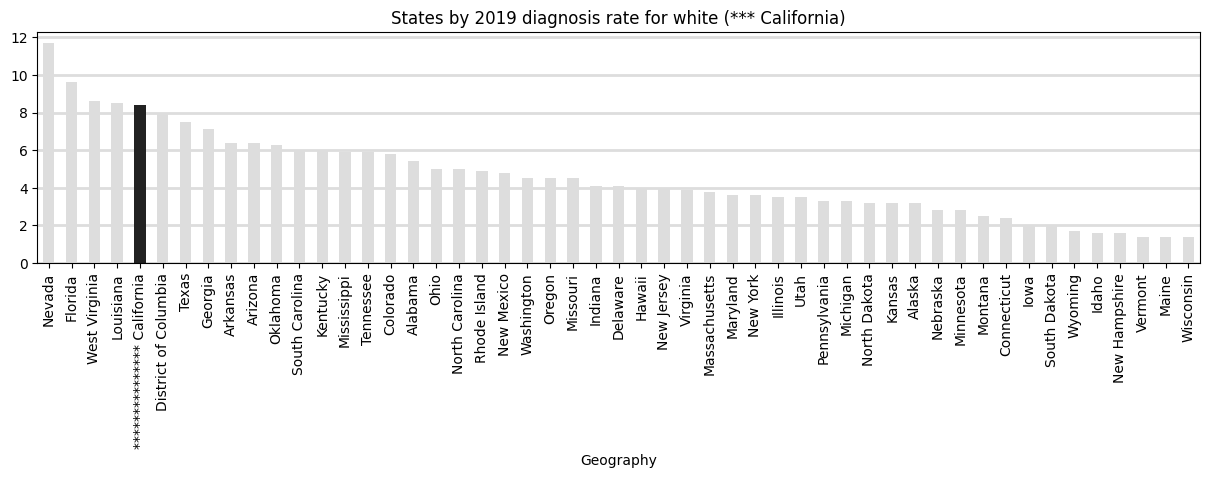

In [38]:
state_bars(
    sub_timeseries(get_data("state-newdiagnosis-race.csv"))["White"]["2019"].sort_values(ascending=False),
    title="States by 2019 diagnosis rate for white (*** California)"
)

### State rank based on diagnosis rates of racial subgroups
Ranked from highest to lowest rate, so rank of 1 has the highest rate, sorted by 2019 rank

In [39]:
print ("California state rank for black diagnosis rate")

just_California(
    sub_timeseries(get_data("state-newdiagnosis-race.csv"))["Black/African American"].rank(ascending=False)\
    .sort_values(by="2019",ascending=False)
)

California state rank for black diagnosis rate


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
California,16.0,26.0,14.5,15.0,19.0


In [40]:
print ("State rank for Hispanic diagnosis rate")

just_California(
    sub_timeseries(get_data("state-newdiagnosis-race.csv"))["Hispanic/Latino"].rank(ascending=False)\
    .sort_values(by="2019",ascending=False)
)

State rank for Hispanic diagnosis rate


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
California,15.0,21.0,18.0,21.0,20.0


In [41]:
print ("State rank for white diagnosis rate")

just_California(
    sub_timeseries(get_data("state-newdiagnosis-race.csv"))["White"].rank(ascending=False)\
    .sort_values(by="2019",ascending=False)
)

State rank for white diagnosis rate


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
California,4.5,5.0,4.0,6.0,7.5


### Prevalence rates by state for racial subgroups

In [42]:
print ("U.S. and California state prevalence for black/african american")

us_CA_timeseries("prev","Black/African American")

U.S. and California state prevalence for black/african american


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,45.7,44.5,36.3,41.2,41.6
California,41.4,38.4,35.1,40.1,37.7


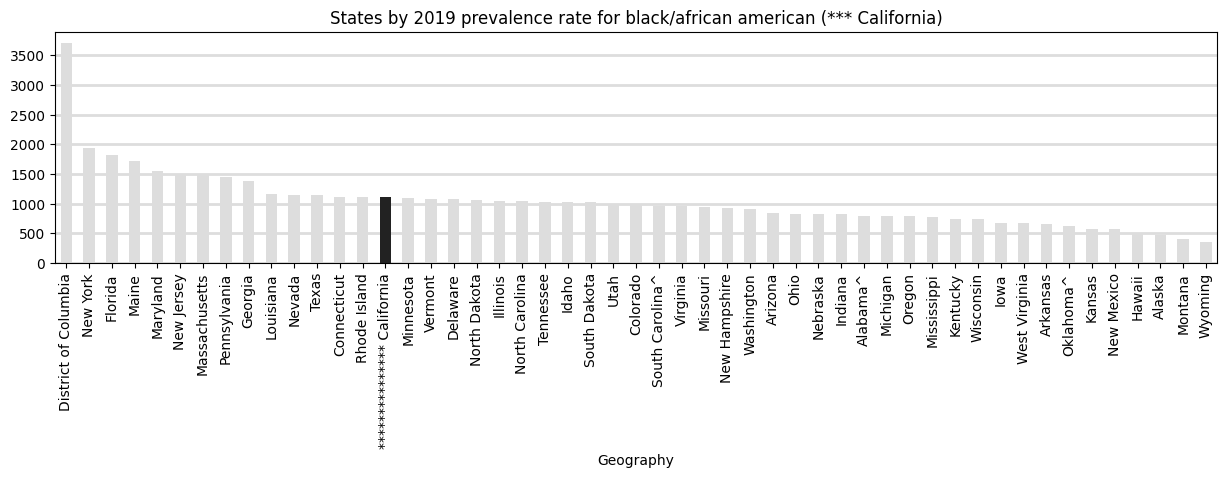

In [43]:
state_bars(
    sub_timeseries(get_data("state-prev-race.csv"))["Black/African American"]["2019"].sort_values(ascending=False),
    title="States by 2019 prevalence rate for black/african american (*** California)"
)

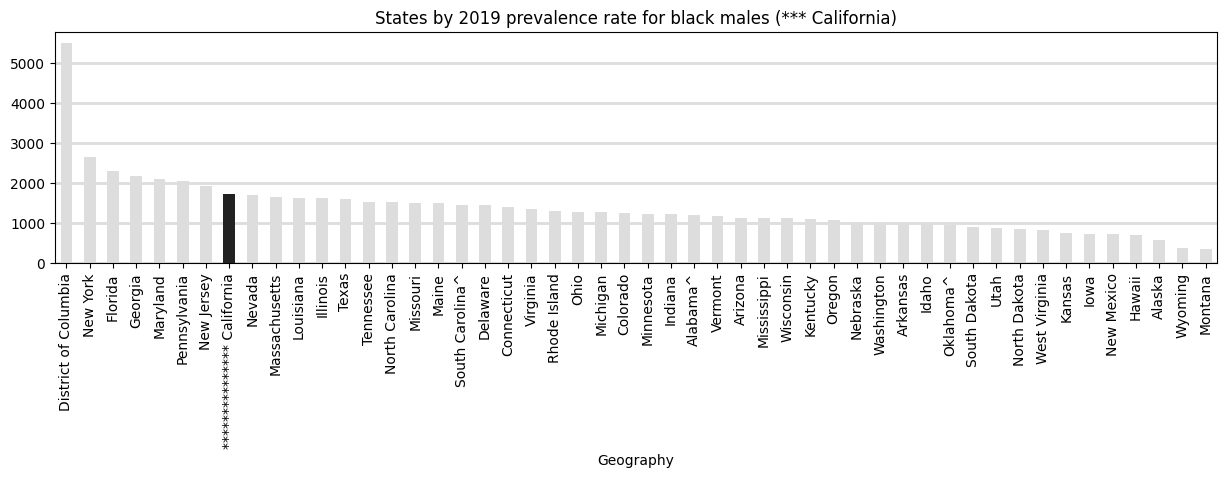

In [44]:
state_bars(
    multi_sub_timeseries(get_data("state-prev-race-gender.csv"),sub_cols=["Race/Ethnicity","Sex"])["Black/African American"]["Male"]["2019"].sort_values(ascending=False),
    title="States by 2019 prevalence rate for black males (*** California)"
)

### Question: What California counties stand out for prevalence and diagnoses?

In [70]:
print ("Prevalence of top California Counties")

top_CA_Counties = just_California(time_series(get_data("county-prev-overall.csv")).
                                  sort_values(by="2022", ascending=False)).head(10)
print(top_CA_Counties["2022"])

Prevalence of top New England Counties
Geography
San Francisco County, CA    1589.3
Los Angeles County, CA       611.5
Riverside County, CA         512.1
San Diego County, CA         493.1
Amador County, CA            490.2
Alameda County, CA           426.3
Solano County, CA            360.6
Sacramento County, CA        351.4
Sonoma County, CA            343.2
Marin County, CA             340.0
Name: 2022, dtype: float64


In [77]:
print (" National prevalence rank of most-prevalent CA counties (lower rank is worse)")
print ("Any rank below 300 is in the top 10% of worst counties")

National_prev_CA_counties = just_California(
    time_series(get_data("county-prev-overall.csv"))\
    .sort_values(by="2022", ascending=False)\
    .rank(ascending=False)
).head(10)
print(National_prev_CA_counties["2022"])

 National prevalence rank of most-prevalent CA counties (lower rank is worse)
Any rank below 300 is in the top 10% of worst counties
Geography
San Francisco County, CA      9.0
Los Angeles County, CA      118.5
Riverside County, CA        189.5
San Diego County, CA        215.0
Amador County, CA           218.0
Alameda County, CA          307.0
Solano County, CA           412.0
Sacramento County, CA       434.0
Sonoma County, CA           445.5
Marin County, CA            454.0
Name: 2022, dtype: float64


In [78]:
print ("Diagnosis rate of top California Counties and U.S.")

just_California(
    time_series(
        pd.concat([
            get_data("us-newdiagnosis-overall.csv"),
            get_data("county-newdiagnosis-overall.csv")
        ])
    )
).sort_values(by="2022", ascending=False).head(20)

Diagnosis rate of top New England Counties and U.S.


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
"San Francisco County, CA",30.0,26.6,20.1,26.2,29.4
"Kern County, CA",21.5,25.4,22.5,25.1,27.7
"Fresno County, CA",13.6,14.5,15.9,18.3,20.8
"Los Angeles County, CA",20.4,18.8,16.9,18.2,19.2
"Solano County, CA",12.3,10.6,13.1,11.3,18.4
"San Bernardino County, CA",15.0,16.8,14.9,16.6,16.0
"Riverside County, CA",13.1,13.2,11.8,13.3,15.5
"San Joaquin County, CA",11.0,12.2,13.2,15.6,15.4
"Alameda County, CA",14.3,15.4,11.3,13.3,14.7


In [79]:
print ("Black prevelance rate of top New England Counties")

just_California(
    sub_timeseries(
        pd.concat([
            get_data("us-prev-race.csv"),
            get_data("county-prev-race.csv")
        ])
    )["Black/African American"]
).sort_values(by="2022", ascending=False).head(12)[["2022"]] 

Black prevelance rate of top New England Counties


Year,2022
Geography,
"San Francisco County, CA",3948.4
"Marin County, CA",1764.1
"Alameda County, CA",1537.7
"Los Angeles County, CA",1409.8
"Mendocino County, CA",1376.7
United States,1243.8
"San Diego County, CA",1191.7
"Lake County, CA",1080.5
"San Mateo County, CA",1054.0


In [80]:
print ("Hispanic prevelance rate of top New England Counties")


just_California(
    sub_timeseries(
        pd.concat([
            get_data("us-prev-race.csv"),
            get_data("county-prev-race.csv")
        ])
    )["Hispanic/Latino"]
).sort_values(by="2022", ascending=False).head(25)[["2022"]]

Hispanic prevelance rate of top New England Counties


Year,2022
Geography,
"San Francisco County, CA",2698.7
"Marin County, CA",685.6
"San Diego County, CA",644.7
"Los Angeles County, CA",627.8
United States,533.6
"Alameda County, CA",494.9
"Santa Clara County, CA",471.6
"San Mateo County, CA",448.2
"Orange County, CA",430.0


Distribution of new diagnosis rates among CA counties
count    42.000000
mean      9.857143
std       7.199293
min       0.000000
25%       5.300000
50%       9.600000
75%      14.225000
max      29.400000
Name: 2022, dtype: float64


<Axes: ylabel='Frequency'>

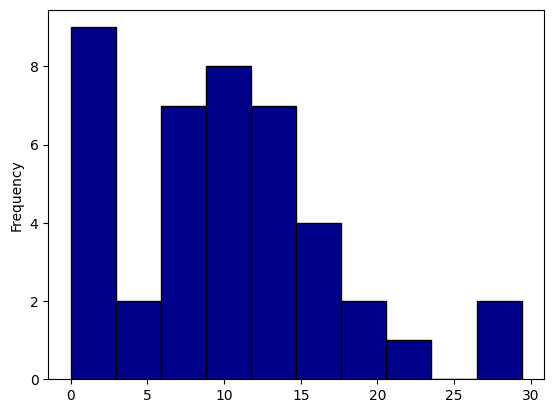

In [86]:
print ("Distribution of new diagnosis rates among CA counties")
print (just_California(time_series(get_data("county-newdiagnosis-overall.csv")))["2022"].describe())
just_California(time_series(get_data("county-newdiagnosis-overall.csv")))["2022"].plot.hist(color = 'darkblue', edgecolor = 'black')

### Computing Inequality

In [95]:
def ratio(a, b):
    
    return a / b

def ts_ratio(dfa, dfb):
    
    ret = dfa.copy()
    for c in dfa.columns:
        ret[c] = ret[c] / dfb[c]
        
    return ret

### Computing CA diagnosis disparity

In [94]:
just_California(
    pd.concat([
        multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"),sub_cols=["Race/Ethnicity", "Sex"])["Black/African American"]["Male"],
        multi_sub_timeseries(get_data("state-newdiagnosis-race-gender.csv"),sub_cols=["Race/Ethnicity", "Sex"])["Black/African American"]["Male"]
    ])
)

Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,72.2,70.9,58.8,65.7,66.3
California,66.9,61.3,57.4,66.9,60.7


In [96]:
just_California(
    pd.concat([
        multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"),sub_cols=["Race/Ethnicity", "Sex"])["Hispanic/Latino"]["Male"],
        multi_sub_timeseries(get_data("state-newdiagnosis-race-gender.csv"),sub_cols=["Race/Ethnicity", "Sex"])["Hispanic/Latino"]["Male"]
    ])
)

Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,37.8,37.0,29.4,35.8,40.8
California,35.6,34.8,30.5,33.8,38.9


In [97]:
just_California(
    pd.concat([
        multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"),sub_cols=["Race/Ethnicity", "Sex"])["White"]["Male"],
        multi_sub_timeseries(get_data("state-newdiagnosis-race-gender.csv"),sub_cols=["Race/Ethnicity", "Sex"])["White"]["Male"]
    ])
)

Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,9.3,8.8,7.5,8.8,8.7
California,15.6,14.7,12.5,13.7,13.7


In [99]:
print ("HIV diagnosis in US Black/Hispanic male ratio")

ts_ratio(
    multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"))["Black/African American"]["Male"],
    multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"))["Hispanic/Latino"]["Male"],
)

HIV diagnosis in US Black/Hispanic male ratio


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,1.910053,1.916216,2.0,1.835196,1.625


In [101]:
print ("HIV diagnosis in US black/white male ratio")

ts_ratio(
    multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"))["Black/African American"]["Male"],
    multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"))["White"]["Male"],
)

HIV diagnosis in US black/white male ratio


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,7.763441,8.056818,7.84,7.465909,7.62069


In [102]:
#US black/hispanic both male and female ratio

ts_ratio(
    sub_timeseries(get_data("us-newdiagnosis-race.csv"))["Black/African American"],
    sub_timeseries(get_data("us-newdiagnosis-race.csv"))["Hispanic/Latino"],
)

Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,2.115741,2.109005,2.160714,2.009756,1.777778


### Diagnosis disparity ratio by race only in California

In [103]:
print ("Black-white new diagnosis disparity ratio in US and California")

just_California(
    ts_ratio(
        pd.concat([
            sub_timeseries(get_data("us-newdiagnosis-race.csv"))["Black/African American"],
            sub_timeseries(get_data("state-newdiagnosis-race.csv"))["Black/African American"]
        ]),
        pd.concat([
            sub_timeseries(get_data("us-newdiagnosis-race.csv"))["White"],
            sub_timeseries(get_data("state-newdiagnosis-race.csv"))["White"]
        ])
    )
)

Black-white new diagnosis disparity ratio in California


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,8.462963,8.557692,8.25,7.923077,7.849057
California,4.704545,4.571429,4.68,4.890244,4.597561


### Diagnosis disparity ratio by race and gender

In [104]:
print ("Black-white male new diagnosis disparity ratio")

just_California(
    ts_ratio(
        pd.concat([
            multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"))["Black/African American"]["Male"],
            multi_sub_timeseries(get_data("state-newdiagnosis-race-gender.csv"))["Black/African American"]["Male"]
        ]),
        pd.concat([
            multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"))["White"]["Male"],
            multi_sub_timeseries(get_data("state-newdiagnosis-race-gender.csv"))["White"]["Male"]
        ])
    )
)

Black-white male new diagnosis disparity ratio


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,7.763441,8.056818,7.840,7.465909,7.620690
California,4.288462,4.170068,4.592,4.883212,4.430657


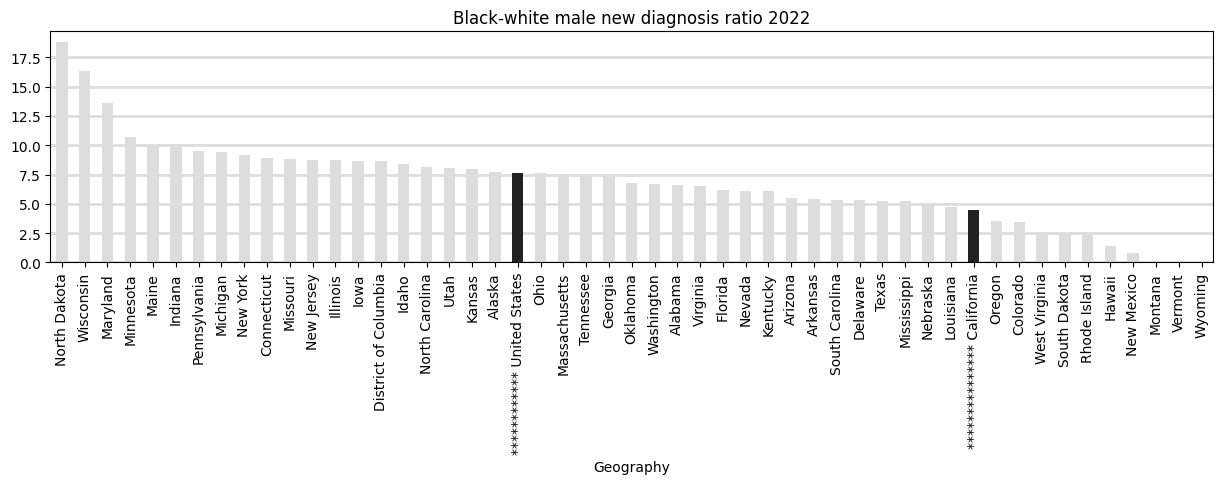

In [107]:
state_bars(ts_ratio(
    pd.concat([
        multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"))["Black/African American"]["Male"],
        multi_sub_timeseries(get_data("state-newdiagnosis-race-gender.csv"))["Black/African American"]["Male"]
    ]),
    pd.concat([
        multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"))["White"]["Male"],
        multi_sub_timeseries(get_data("state-newdiagnosis-race-gender.csv"))["White"]["Male"]
    ])
)["2022"].sort_values(ascending=False),
          title="Black-white male new diagnosis ratio 2022")
    

In [108]:
print ("Hispanic-white new diagnosis disparity ratio")

just_California(
    ts_ratio(
        pd.concat([
            multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"))["Hispanic/Latino"]["Male"],
            multi_sub_timeseries(get_data("state-newdiagnosis-race-gender.csv"))["Hispanic/Latino"]["Male"]
        ]),
        pd.concat([
            multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"))["White"]["Male"],
            multi_sub_timeseries(get_data("state-newdiagnosis-race-gender.csv"))["White"]["Male"]
        ])
    )
)

Hispanic-white new diagnosis disparity ratio


Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
Geography,,,,,
United States,4.064516,4.204545,3.92,4.068182,4.689655
California,2.282051,2.367347,2.44,2.467153,2.839416


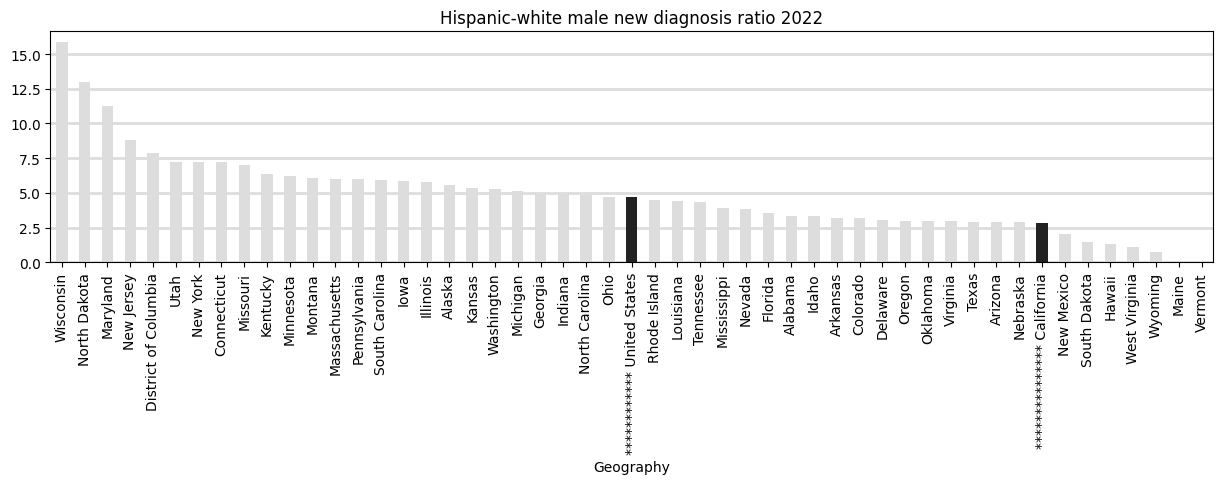

In [109]:
state_bars(ts_ratio(
    pd.concat([
        multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"))["Hispanic/Latino"]["Male"],
        multi_sub_timeseries(get_data("state-newdiagnosis-race-gender.csv"))["Hispanic/Latino"]["Male"]
    ]),
    pd.concat([
        multi_sub_timeseries(get_data("us-newdiagnosis-race-gender.csv"))["White"]["Male"],
        multi_sub_timeseries(get_data("state-newdiagnosis-race-gender.csv"))["White"]["Male"]
    ])
)["2022"].sort_values(ascending=False),
          title="Hispanic-white male new diagnosis ratio 2022")
    

### Prevalence disparity by race and gender

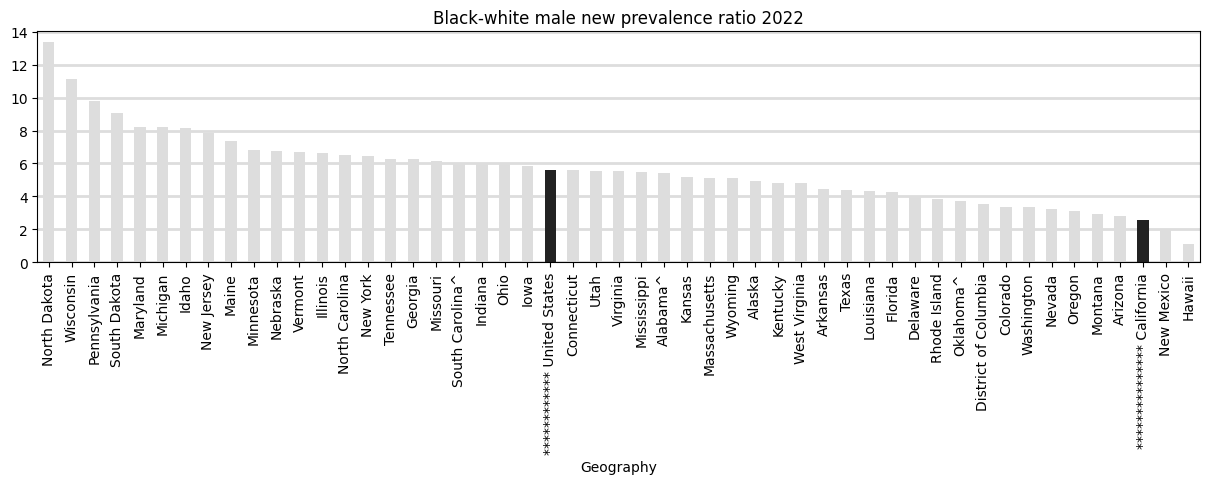

In [110]:
state_bars(ts_ratio(
    pd.concat([
        multi_sub_timeseries(get_data("us-prev-race-gender.csv"))["Black/African American"]["Male"],
        multi_sub_timeseries(get_data("state-prev-race-gender.csv"))["Black/African American"]["Male"]
    ]),
    pd.concat([
        multi_sub_timeseries(get_data("us-prev-race-gender.csv"))["White"]["Male"],
        multi_sub_timeseries(get_data("state-prev-race-gender.csv"))["White"]["Male"]
    ])
)["2022"].sort_values(ascending=False),
          title="Black-white male new prevalence ratio 2022")
    

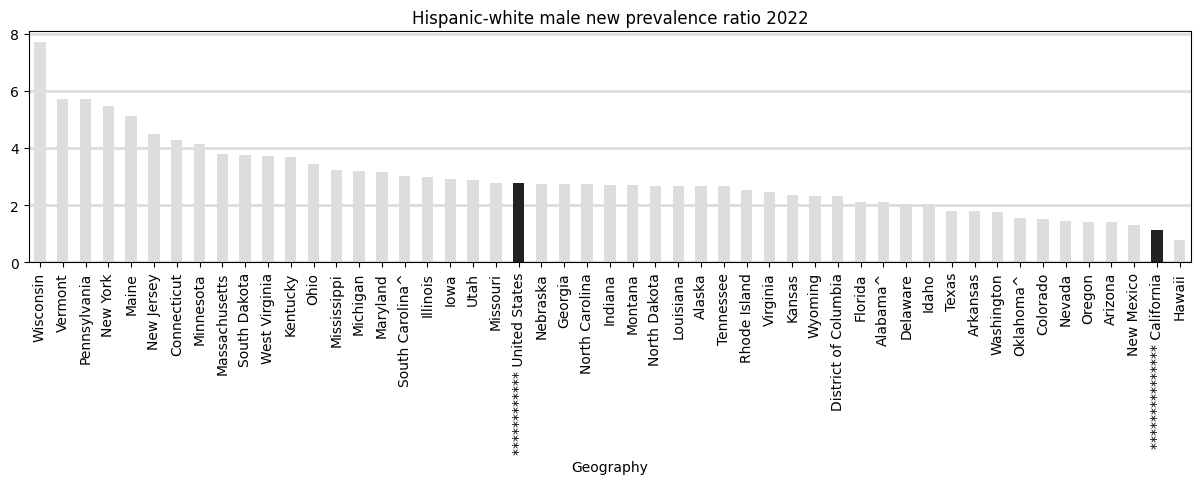

In [112]:
state_bars(ts_ratio(
    pd.concat([
        multi_sub_timeseries(get_data("us-prev-race-gender.csv"))["Hispanic/Latino"]["Male"],
        multi_sub_timeseries(get_data("state-prev-race-gender.csv"))["Hispanic/Latino"]["Male"]
    ]),
    pd.concat([
        multi_sub_timeseries(get_data("us-prev-race-gender.csv"))["White"]["Male"],
        multi_sub_timeseries(get_data("state-prev-race-gender.csv"))["White"]["Male"]
    ])
)["2022"].sort_values(ascending=False),
          title="Hispanic-white male new prevalence ratio 2022")
    

### Prevalence disparity ratios at the county level

In [115]:
ts_ratio(
    multi_sub_timeseries(get_data("county-prev-race.csv"), sub_cols=["Race/Ethnicity"])["Black/African American"],
    multi_sub_timeseries(get_data("county-prev-race.csv"), sub_cols=["Race/Ethnicity"])["White"]
).describe()

Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
count,38.000000,37.000000,37.000000,38.000000,38.000000
mean,3.614784,3.730892,3.641988,3.620482,3.642976
std,1.612993,1.543933,1.472953,1.468699,1.393684
min,0.000000,0.557919,0.679816,0.724746,0.773718
25%,2.840214,2.814433,2.821001,2.853510,2.879757
50%,3.528932,3.522784,3.397757,3.458129,3.453225
75%,4.324397,4.388919,4.310745,4.162702,4.310183
max,8.712546,7.845224,7.927677,8.606374,7.558269


In [116]:
ts_ratio(
    multi_sub_timeseries(get_data("county-prev-race.csv"), sub_cols=["Race/Ethnicity"])["White"],
    multi_sub_timeseries(get_data("county-prev-race.csv"), sub_cols=["Race/Ethnicity"])["White"]
).describe()

Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
count,42.0,42.0,42.0,42.0,42.0
mean,1.0,1.0,1.0,1.0,1.0
std,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.0,1.0
75%,1.0,1.0,1.0,1.0,1.0
max,1.0,1.0,1.0,1.0,1.0


<Axes: ylabel='Frequency'>

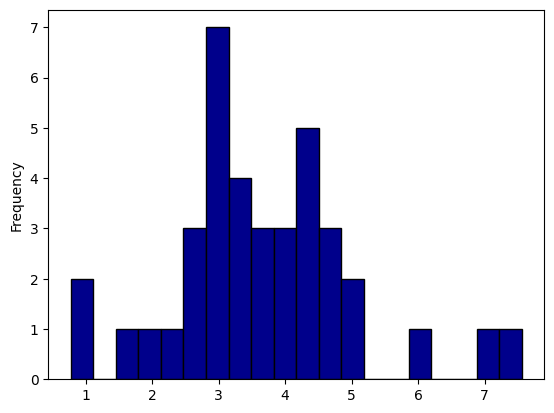

In [118]:
ts_ratio(
    multi_sub_timeseries(get_data("county-prev-race.csv"), sub_cols=["Race/Ethnicity"])["Black/African American"],
    multi_sub_timeseries(get_data("county-prev-race.csv"), sub_cols=["Race/Ethnicity"])["White"]
)["2022"].plot.hist(bins=20, color = "darkblue", edgecolor = "black")

In [120]:
print ("California Counties and US black-white prevalence ratio, 2022")

just_California(
    pd.concat([
        ts_ratio(
            multi_sub_timeseries(get_data("us-prev-race.csv"), sub_cols=["Race/Ethnicity"])["Black/African American"],      
            multi_sub_timeseries(get_data("us-prev-race.csv"), sub_cols=["Race/Ethnicity"])["White"]
        ),
        ts_ratio(
            multi_sub_timeseries(get_data("county-prev-race.csv"), sub_cols=["Race/Ethnicity"])["Black/African American"],      
            multi_sub_timeseries(get_data("county-prev-race.csv"), sub_cols=["Race/Ethnicity"])["White"]
        )
    ])
)["2022"].dropna().sort_values(ascending=False).to_frame()

California Counties and US black-white prevalence ratio, 2022


,2022
Geography,
"Marin County, CA",7.558269
United States,6.960269
"Shasta County, CA",6.908391
"Mendocino County, CA",5.880820
"Butte County, CA",5.140648
"San Luis Obispo County, CA",5.000799
"Yolo County, CA",4.728492
"Lake County, CA",4.683572
"Madera County, CA",4.652328


In [122]:
ts_ratio(
    multi_sub_timeseries(get_data("county-prev-race.csv"), sub_cols=["Race/Ethnicity"])["Hispanic/Latino"],
    multi_sub_timeseries(get_data("county-prev-race.csv"), sub_cols=["Race/Ethnicity"])["White"]
).describe()

Year,2018,2019,2020 (COVID-19 Pandemic),2021,2022
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,1.312366,1.323509,1.324851,1.309629,1.316671
std,0.408200,0.421892,0.407289,0.438366,0.460241
min,0.363342,0.358909,0.354496,0.346145,0.340519
25%,1.075212,1.068165,1.099902,1.034589,1.054550
50%,1.272672,1.266904,1.260965,1.209640,1.247781
75%,1.541252,1.575528,1.559651,1.434284,1.517186
max,2.507917,2.694075,2.508283,2.814815,2.937446


<Axes: ylabel='Frequency'>

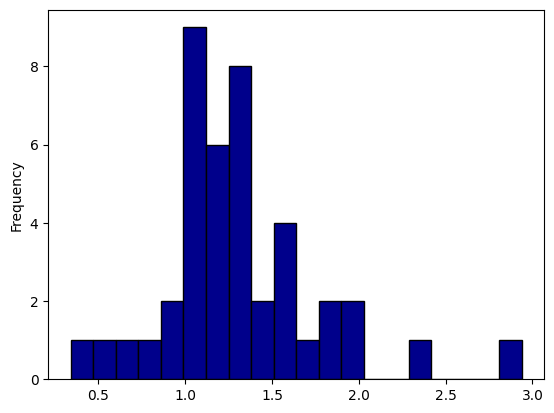

In [124]:
ts_ratio(
    multi_sub_timeseries(get_data("county-prev-race.csv"), sub_cols=["Race/Ethnicity"])["Hispanic/Latino"],
    multi_sub_timeseries(get_data("county-prev-race.csv"), sub_cols=["Race/Ethnicity"])["White"]
)["2022"].plot.hist(bins=20, color = "darkblue", edgecolor = "black")

# I am ending here. We can do many analyses based on this template.